In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import hist
from Disco import distance_corr

hep.style.use("CMS")
mpl.rcParams['figure.facecolor'] = 'white'

In [68]:
scripts = ['suep_single_train.py']
disco_vars = ['ntracks', 'S1']
objs = ['Pfcand', 'bPfcand']
lambdas = [1, 2, 5]

# loop over configurations
dirs = []
for script in scripts:
    for l in lambdas:
        for obj in objs:
            for disco_var in disco_vars:
                
                # define outDir string
                if script != 'suep_single_train.py':
                    # no need to loop over disco_vars if double disco
                    if disco_var != disco_vars[0]: 
                        continue
                    else:
                        outDir = script.split("_")[1] + "_l" + str(l) + "_" + obj
                else:
                    outDir = script.split("_")[1] + "_l" + str(l) + "_" + obj + "_" + disco_var
                
                dirs.append(outDir)

In [69]:
results = []
for inputDir in dirs:
    results.append(np.load("{}/disco_results.npy".format(inputDir)))

In [70]:
out_dir = 'grid_search/'
if not os.path.isdir(out_dir): os.system("mkdir " + out_dir)

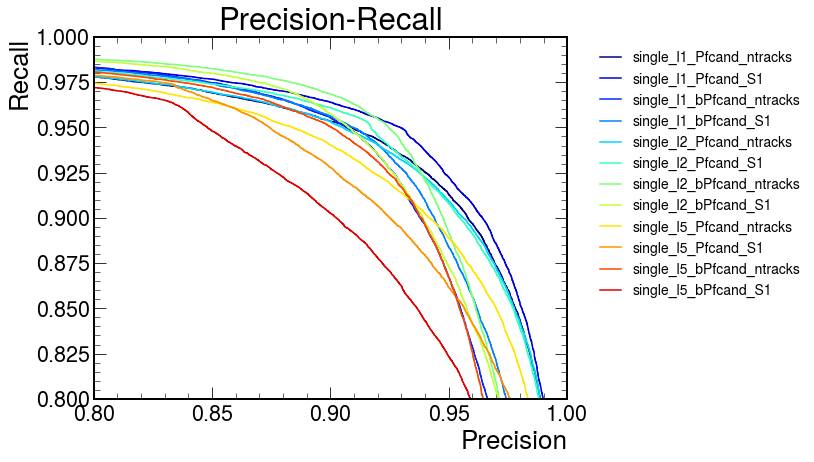

In [71]:
from sklearn.metrics import precision_recall_curve

fig = plt.figure(figsize=(12,7))
ax = fig.subplots()
cmap = plt.cm.jet(np.linspace(0, 1, len(dirs)+1))

y_preds = [r[0] for r in results]
y_tests = [r[2] for r in results]
        
for key, y_pred, y_test, color in zip(dirs, y_preds, y_tests, cmap):
    pre, rec, _ = precision_recall_curve(y_test, y_pred)
    ax.plot(rec, pre, label=key, color=color)

ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_title("Precision-Recall")

ax.set_ylim(0.8,1.0)
ax.set_xlim(0.8,1.0)

ax.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
fig.tight_layout()
fig.savefig('{}/precision-recall-curve'.format(out_dir), bbox_inches='tight')

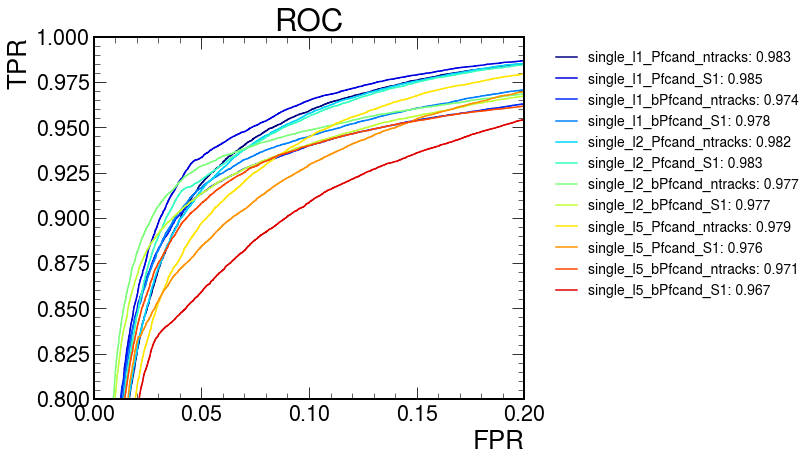

In [72]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(12,7))
ax = fig.subplots()
cmap = plt.cm.jet(np.linspace(0, 1, len(dirs)+1))

y_preds = [r[0] for r in results]
y_tests = [r[2] for r in results]
        
aucs = []
for key, y_pred, y_test, color in zip(dirs, y_preds, y_tests, cmap):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    aucs.append(auc(fpr, tpr))
    ax.plot(fpr, tpr, label=key + ": " + str(round(auc(fpr, tpr),3)), color=color)

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC")

ax.set_xlim(0.0,0.2)
ax.set_ylim(0.8,1.0)

ax.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
fig.tight_layout()
fig.savefig('{}/roc-curve'.format(out_dir), bbox_inches='tight')

single_l1_Pfcand_ntracks
	SR Closure: 0.84
	Precision: 0.93
	Recall: 0.94
single_l1_Pfcand_S1
	SR Closure: 0.66
	Precision: 0.94
	Recall: 0.94
single_l1_bPfcand_ntracks
	SR Closure: 0.55
	Precision: 0.95
	Recall: 0.91
single_l1_bPfcand_S1
	SR Closure: 0.65
	Precision: 0.94
	Recall: 0.92
single_l2_Pfcand_ntracks
	SR Closure: 0.91
	Precision: 0.92
	Recall: 0.94
single_l2_Pfcand_S1
	SR Closure: 0.97
	Precision: 0.93
	Recall: 0.93
single_l2_bPfcand_ntracks
	SR Closure: 0.48
	Precision: 0.96
	Recall: 0.92
single_l2_bPfcand_S1
	SR Closure: 0.74
	Precision: 0.95
	Recall: 0.91
single_l5_Pfcand_ntracks
	SR Closure: 1.08
	Precision: 0.91
	Recall: 0.93
single_l5_Pfcand_S1
	SR Closure: 1.26
	Precision: 0.91
	Recall: 0.91
single_l5_bPfcand_ntracks
	SR Closure: 0.85
	Precision: 0.93
	Recall: 0.92
single_l5_bPfcand_S1
	SR Closure: 0.93
	Precision: 0.9
	Recall: 0.9


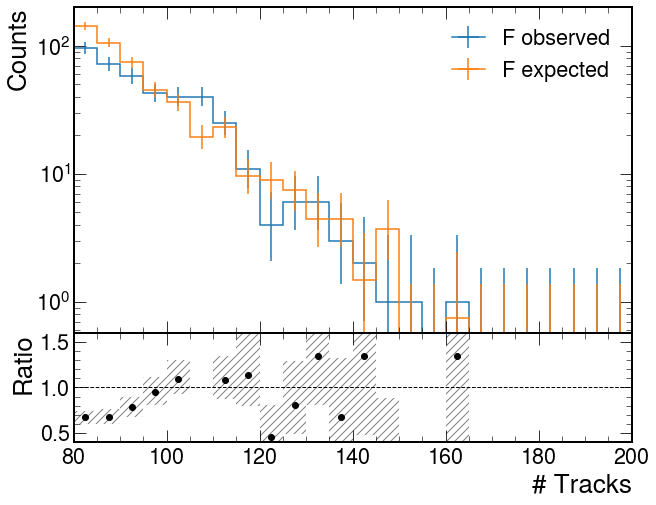

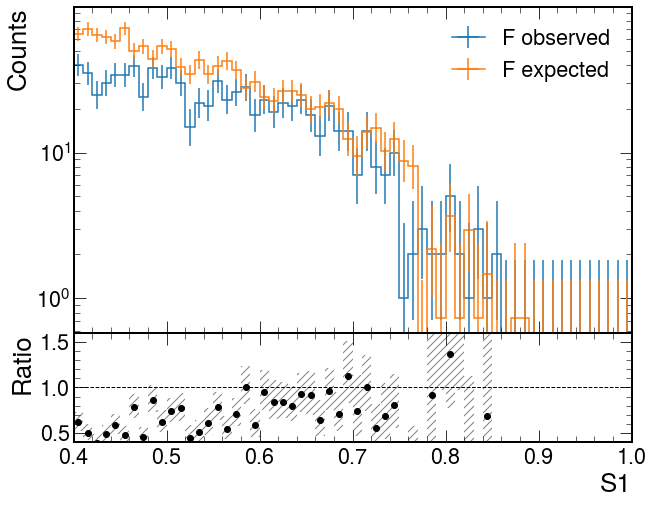

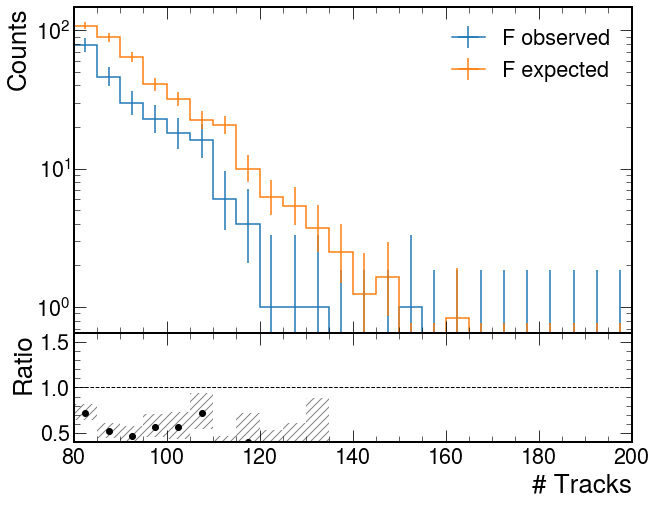

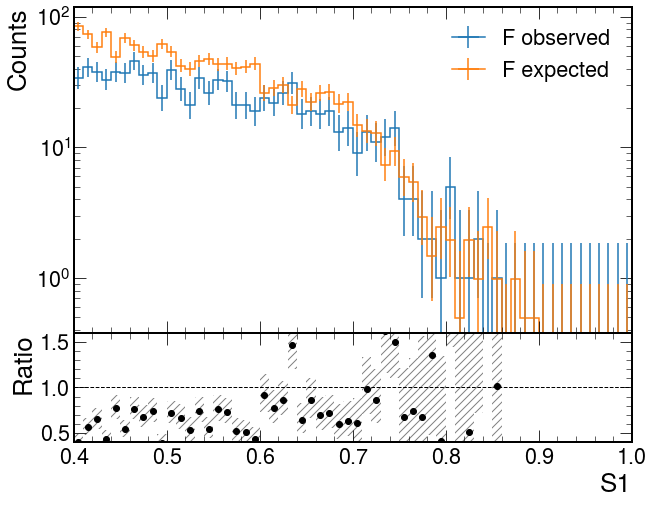

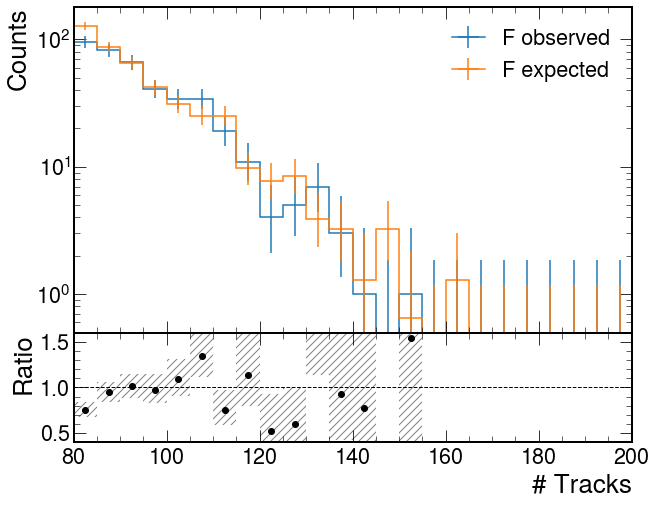

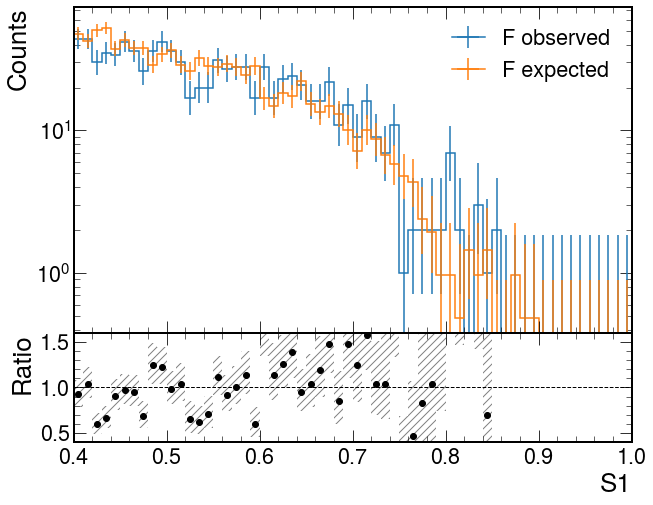

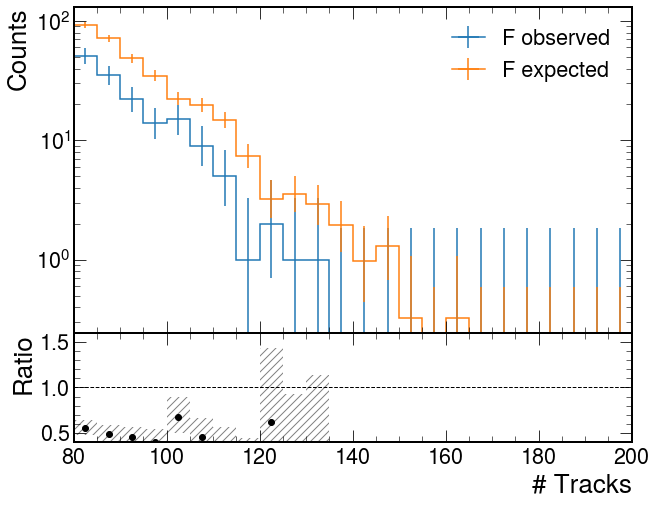

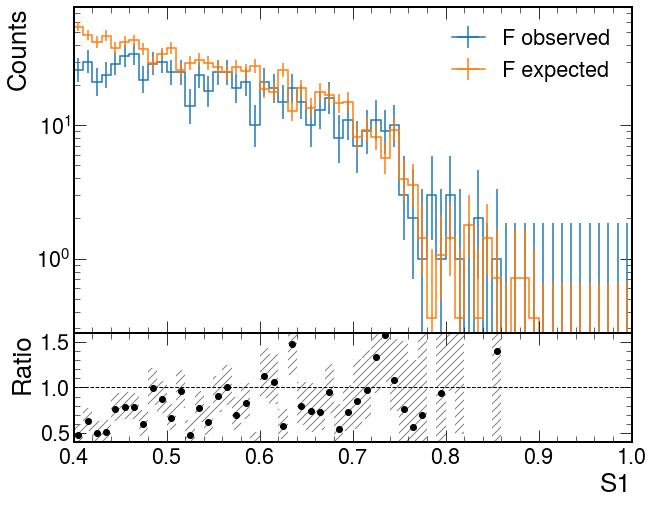

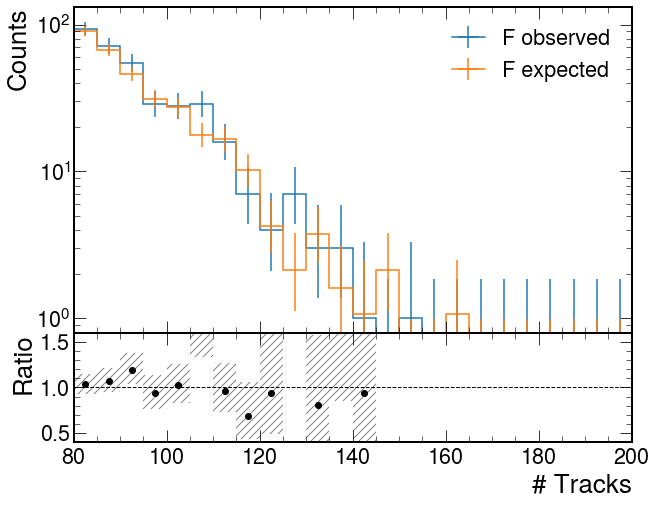

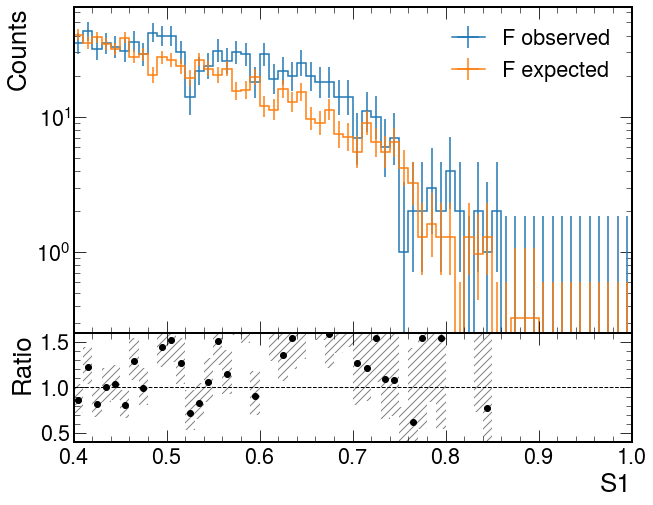

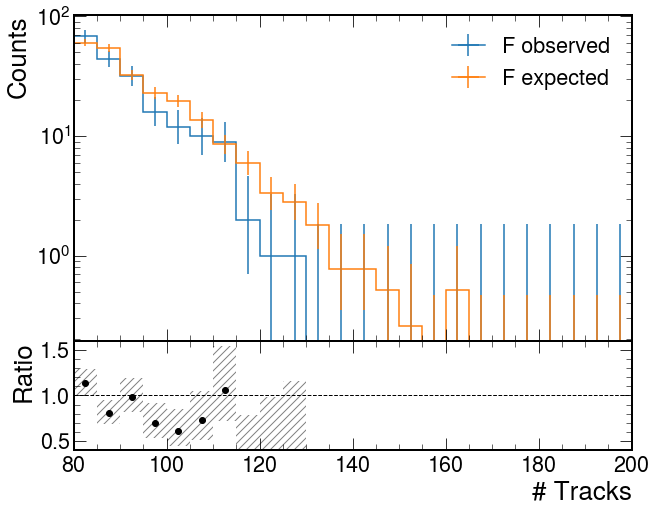

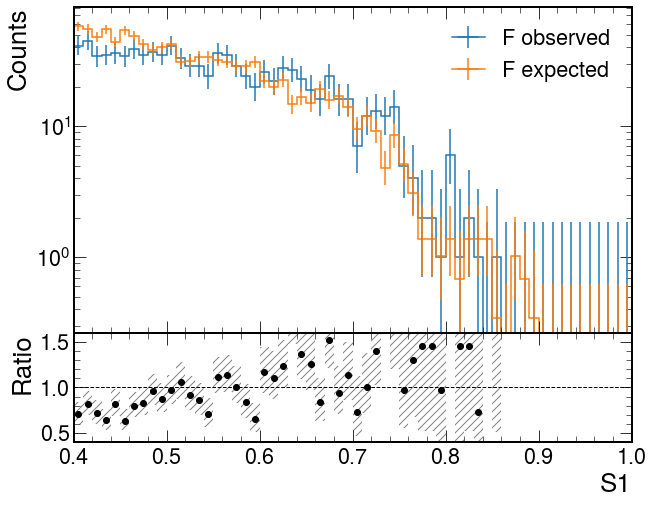

In [166]:
for d, r in zip(dirs, results):
    if 'ntracks' in d:
        disco_var = '# Tracks'
        xmax = 500
        regions = [0.0j, 60j, 80j, 200j]
    elif 'S1' in d:
        disco_var = 'S1'
        xmax = 1.0
        regions = [0.0j, 0.2j, 0.4j, 1.0j]
    else:
        continue
    
    suep_cl1 = r[0][r[2] == 1]
    suep_cl2 = r[1][r[2] == 1]
    qcd_cl1 = r[0][r[2] == 0]
    qcd_cl2 = r[1][r[2] == 0]

    hist_abcd = (
         hist.new
        .Regular(100, 0, 1, name="cl1", label="Classifier Output 1")
        .Regular(100, 0, xmax, name="ntracks", label=disco_var)
        .Weight()
    )

    hist_abcd.fill(qcd_cl1, qcd_cl2)

    hist_abcd_suep = (
         hist.new
        .Regular(100, 0, 1, name="cl1", label="Classifier Output 1")
        .Regular(100, 0, xmax, name="ntracks", label=disco_var)
        .Weight()
    )

    hist_abcd_suep.fill(suep_cl1, suep_cl2)

    A = hist_abcd[0.05j:0.5j:sum,regions[0]:regions[1]]
    B = hist_abcd[0.05j:0.5j:sum,regions[1]:regions[2]]
    C = hist_abcd[0.05j:0.5j:sum,regions[2]:regions[3]]
    D = hist_abcd[0.5j:1.0j:sum,regions[0]:regions[1]]
    E = hist_abcd[0.5j:1.0j:sum,regions[1]:regions[2]]
    F = hist_abcd[0.5j:1.0j:sum,regions[2]:regions[3]]
    F_exp = C * E.sum().value**2 * A.sum().value / (B.sum().value**2 * D.sum().value)

    ratio = F.sum().value/F_exp.sum().value
    
    y_true = r[2]
    y_pred1 = r[0]
    y_pred2 = r[1]
    TP = np.sum(y_true[(y_pred1>0.5) & (y_pred2>regions[2])]) # how many 1's in y_true predicted
    FP = len(y_true[(y_pred1>0.5) & (y_pred2>regions[2])]) - TP # total predicted P minus TP
    FN = np.sum(y_true[(y_pred1<0.5) | (y_pred2<regions[2])]) # how many 1's in y_true not predicted

    if TP + FP == 0: pre = None
    else: pre = TP / (TP + FP)
    if TP + FN == 0: rec = None
    else: rec = TP / (TP + FN)
    
    print(d)
    print("\tSR Closure:", round(ratio,2))
    print("\tPrecision:", round(pre,2))
    print("\tRecall:", round(rec,2))

    fig = plt.figure(figsize=(10, 8))
    main, sub = F.plot_ratio(F_exp,
                    rp_num_label='F observed',
                    rp_denom_label='F expected',
                    rp_uncert_draw_type="bar")
    fig.axes[0].set_yscale("log")
    fig.axes[0].set_xlim(regions[-2].imag,regions[-1].imag)
    fig.axes[1].set_xlabel(disco_var)
    fig.axes[1].set_ylim(0.4,1.6)
    plt.savefig(out_dir+"{}-ABCD.png".format(d))

In [134]:
def precision_recall_2variables(y_pred1, y_pred2, y_true):
    
    xsecs = np.linspace(np.min(y_pred1),np.max(y_pred2),20)
    ysecs = np.linspace(np.min(y_pred2),np.max(y_pred2),20)
    
    pres, recs = [], []
    for x in xsecs:
        for y in ysecs:
            
            TP = np.sum(y_true[(y_pred1>x) & (y_pred2>y)]) # how many 1's in y_true predicted
            FP = len(y_true[(y_pred1>x) & (y_pred2>y)]) - TP # total predicted P minus TP
            FN = np.sum(y_true[(y_pred1<x) | (y_pred2<y)]) # how many 1's in y_true not predicted
            
            if TP + FP == 0: pre = None
            else: pre = TP / (TP + FP)
            if TP + FN == 0: rec = None
            else: rec = TP / (TP + FN)
            
            pres.append(pre)
            recs.append(rec)
            
    return pres, recs

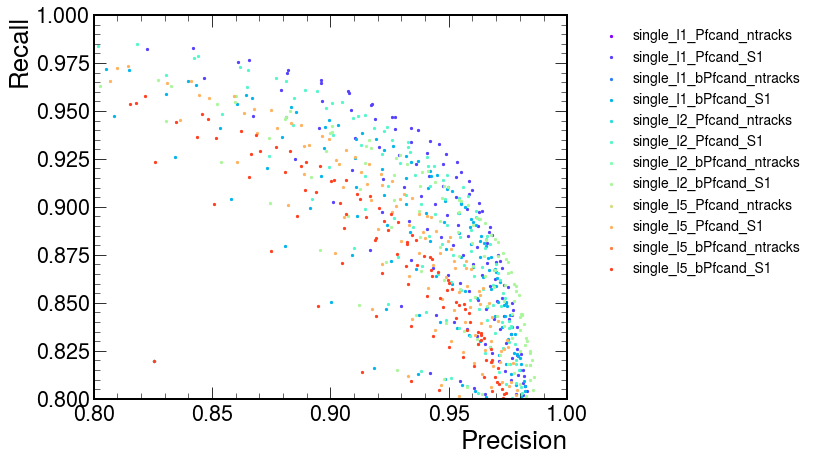

In [167]:
fig = plt.figure(figsize=(12,7))
ax = fig.subplots()
cmap = plt.cm.rainbow(np.linspace(0, 1, len(dirs)+1))

for r, d, c in zip(results, dirs, cmap):
        
    pres, recs = precision_recall_2variables(r[0],r[1],r[2])
    
    ax.scatter(pres, recs, s=5.0, label=d, color=c)
    
ax.set_xlim(0.8,1)
ax.set_ylim(0.8,1)
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
fig.tight_layout()
fig.savefig('{}/precision-recall-curve-2vars'.format(out_dir), bbox_inches='tight')
plt.show()